In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from DSS_analyzer_Mariner import Data1D_GAUGE, Data1D_PumpingCurve
from copy import deepcopy

In [3]:
datapath = "./"
gauge_data_folder = datapath + "s_well/gauge_data/"

# Load pressure gauge
gauge_dataframe = Data1D_GAUGE.Data1D_GAUGE(gauge_data_folder + f"gauge6_data_swell.npz")

# Load pumping curve
pumping_curve_filepath = datapath + f"prod/pumping_curve/pumping_curve_stage7.npz"
pumping_curve = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath)

In [4]:
# Load pumping curve/next stage
pumping_curve_filepath_next = datapath + f"prod/pumping_curve/pumping_curve_stage8.npz"
pumping_curve_next = Data1D_PumpingCurve.Data1D_PumpingCurve(pumping_curve_filepath_next)

In [5]:
# Crop the pressure gauge data,
start_time = pumping_curve.get_start_time()
end_time = pumping_curve_next.get_end_time()
gauge_dataframe.crop(start_time, end_time)

In [6]:
gauge_md_index = np.array([265, 520,  789, 1043, 1312, 1567])
frac_hit_index = np.array([589, 830])

In [7]:
# Interpolate the gauge data for any time point, the function would return the interpolated value
from scipy.interpolate import interp1d
def interpolate_gauge_data(time):
    gauge_data = gauge_dataframe.data
    gauge_taxis = gauge_dataframe.calculate_time()
    gauge_interpolator = interp1d(gauge_taxis * 3600, gauge_data, kind='linear')
    return gauge_interpolator(time)

In [8]:
# Simulator parameters
nx = 5000
# nx = 1800
total_time = 13000
d = 140 * np.ones(nx)
dx = 1
x = np.arange(0, nx*dx, dx)
x = x - nx * dx / 2 # make the center of the domain as 0
u_snapshot = [] # store the snapshot of u
u_current = np.zeros(nx)
t = list([0]) # store the time points
dt = 0
dt_init = 10.0

# Phase 1
## Define simulator

In [9]:
# Simulator
def build_matrix_phase1(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
    # Source term
    phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0])
    A[phase1_frac_hit_index, :] = 0
    A[phase1_frac_hit_index, phase1_frac_hit_index] = 1
    
    return A

def build_rhs_phase1(u_current, t):
    rhs = u_current.copy()
    rhs[0] = 0
    rhs[-1] = 0
    # Source term.
    phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0])
    rhs[phase1_frac_hit_index] = interpolate_gauge_data(t)
    # print(f"Time: {t}, Source: {interpolate_gauge_data(t)}") # debug info
    return rhs

In [10]:
# Create snapshot
u_current = gauge_dataframe.data[0] * np.ones_like(u_current) # initial condition
u_snapshot.append(u_current.copy())

In [11]:
# 
# full step solver
def full_step_phase1(u_current, dt, t):
    A = build_matrix_phase1(dt)
    rhs = build_rhs_phase1(u_current, t)
    return np.linalg.solve(A, rhs)

# half step solver
def half_step_phase1(u_current, dt, t):
    dt_half = dt / 2
    A_half = build_matrix_phase1(dt_half)
    rhs_half = build_rhs_phase1(u_current, t)
    u_middle = np.linalg.solve(A_half, rhs_half)
    
    b_half = build_rhs_phase1(u_middle, t)
    u_final = np.linalg.solve(A_half, b_half)
    
    return u_final

In [12]:
# Time sampling optimizer
def adjust_dt(dt_current, error, tol=1e-3):
    safety_factor = 0.9
    p = 2
    
    dt_new = safety_factor * dt_current * (tol / max(error, 1e-16))**(1/(p+1))
    
    dt_new = min(2.0 * dt_init, max(0.5 * dt_current, dt_new))
    
    return dt_new

In [13]:
# test the full step
dt = dt_init

u_current = full_step_phase1(u_current, dt, t[-1])
u_snapshot.append(u_current.copy())
t.append(t[-1] + dt)

## Simulation: stage 1

In [14]:
while t[-1] < total_time: # time loop
    print("dt = ", dt)
    # calculate the full step
    u_current = full_step_phase1(u_current, dt, t[-1])
    
    # calculate the half step
    u_current_half = half_step_phase1(u_current, dt, t[-1])
    
    # calculate the error
    error = np.linalg.norm(u_current_half - u_current) / np.linalg.norm(u_current)
    # print(f"Time: {t[-1]}, Error: {error}")
    # adjust the time step
    dt = adjust_dt(dt, error)
    
    if error <= 1e-3:
        # store the snapshot if the error is small enough.
        u_snapshot.append(u_current.copy())
        t.append(t[-1] + dt)
        
        # update the time step
        dt = min(dt, 10)
    else:
        # the error is too large, reduce the time step. Don't store the snapshot.
        dt = max(0.5 * dt, 0.5)
    
    # store the snapshot
    u_snapshot.append(u_current.copy())
    print(f"Time: {t[-1]}, Error: {error:.6f}")
    t.append(t[-1] + dt)

dt =  10.0
Time: 30.0, Error: 0.000001
dt =  10
Time: 60.0, Error: 0.000003
dt =  10
Time: 90.0, Error: 0.000005
dt =  10
Time: 120.0, Error: 0.000006
dt =  10
Time: 150.0, Error: 0.000007
dt =  10
Time: 180.0, Error: 0.000005
dt =  10
Time: 210.0, Error: 0.000005
dt =  10
Time: 240.0, Error: 0.000017
dt =  10
Time: 270.0, Error: 0.000029
dt =  10
Time: 300.0, Error: 0.000037
dt =  10
Time: 330.0, Error: 0.000041
dt =  10
Time: 360.0, Error: 0.000044
dt =  10
Time: 390.0, Error: 0.000045
dt =  10
Time: 420.0, Error: 0.000046
dt =  10
Time: 450.0, Error: 0.000047
dt =  10
Time: 480.0, Error: 0.000048
dt =  10
Time: 510.0, Error: 0.000048
dt =  10
Time: 540.0, Error: 0.000048
dt =  10
Time: 570.0, Error: 0.000048
dt =  10
Time: 600.0, Error: 0.000048
dt =  10
Time: 630.0, Error: 0.000048
dt =  10
Time: 660.0, Error: 0.000048
dt =  10
Time: 690.0, Error: 0.000049
dt =  10
Time: 720.0, Error: 0.000051
dt =  10
Time: 750.0, Error: 0.000052
dt =  10
Time: 780.0, Error: 0.000052
dt =  10
Time

# Phase 2

In [15]:
total_time_interval = 3000 # I define the time in this phase

## Simulator

In this case, I'll make the fractures in the stage 1 keeps the pressure and permeability. In this phase 

In [16]:
# define Simulator
def build_matrix_phase2(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
    # Source term
    phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0])
    A[phase1_frac_hit_index, :] = 0
    A[phase1_frac_hit_index, phase1_frac_hit_index] = 1
    
    return A

def build_rhs_phase2(u_current, t):
    rhs = u_current.copy()
    rhs[0] = 0
    rhs[-1] = 0
    # Source term. In this case, use the pressure data in pg.
    phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0])
    rhs[phase1_frac_hit_index] = interpolate_gauge_data(t)
    return rhs

In [17]:
# full step
def full_step_phase2(u_current, dt, t):
    A = build_matrix_phase2(dt)
    rhs = build_rhs_phase2(u_current, t)
    return np.linalg.solve(A, rhs)

# half step
def half_step_phase2(u_current, dt, t):
    dt_half = dt / 2
    A_half = build_matrix_phase2(dt_half)
    rhs_half = build_rhs_phase2(u_current, t)
    u_middle = np.linalg.solve(A_half, rhs_half)
    
    b_half = build_rhs_phase2(u_middle, t)
    u_final = np.linalg.solve(A_half, b_half)
    
    return u_final

In [18]:
# Wrapping up the simulation.
def pressure_diffusion_phase2(u_init, d):
    total_time_phase2 = total_time + total_time_interval # decide the end time
    # Create a new taxis to handle multiple d change
    dt = dt_init
    taxis_tmp = t.copy()
    u_snapshot_tmp = u_snapshot.copy()
    u_current = u_init.copy()
    while taxis_tmp[-1] < total_time_phase2: 
        u_current = full_step_phase1(u_current, dt, taxis_tmp[-1])
        u_current_half = half_step_phase1(u_current, dt, taxis_tmp[-1])
        error = np.linalg.norm(u_current_half - u_current) / np.linalg.norm(u_current)

        dt = adjust_dt(dt, error)


        if error <= 1e-3:
            # store the snapshot if the error is small enough.
            u_snapshot_tmp.append(u_current.copy())
            taxis_tmp.append(taxis_tmp[-1] + dt)

            # update the time step
            dt = min(dt, 10)
        else:
            # the error is too large, reduce the time step. Don't store the snapshot.
            dt = max(0.5 * dt, 0.5)

        # store the snapshot
        u_snapshot_tmp.append(u_current.copy())
        print(f"Time: {taxis_tmp[-1]}, Error: {error:.6f}")
        taxis_tmp.append(taxis_tmp[-1] + dt)

    # then return the copy. Though it is space consuming
    result_snapshot = np.array(u_snapshot_tmp)
    result_t = np.array(taxis_tmp)

    return result_snapshot, result_t

In [19]:
u_snapshot, t = pressure_diffusion_phase2(u_snapshot[-1], d)

Time: 13042.258297121147, Error: 0.000036
Time: 13072.258297121147, Error: 0.000036
Time: 13102.258297121147, Error: 0.000036
Time: 13132.258297121147, Error: 0.000036
Time: 13162.258297121147, Error: 0.000036
Time: 13192.258297121147, Error: 0.000035
Time: 13222.258297121147, Error: 0.000035
Time: 13252.258297121147, Error: 0.000035
Time: 13282.258297121147, Error: 0.000035
Time: 13312.258297121147, Error: 0.000035
Time: 13342.258297121147, Error: 0.000035
Time: 13372.258297121147, Error: 0.000035
Time: 13402.258297121147, Error: 0.000035
Time: 13432.258297121147, Error: 0.000036
Time: 13462.258297121147, Error: 0.000036
Time: 13492.258297121147, Error: 0.000036
Time: 13522.258297121147, Error: 0.000037
Time: 13552.258297121147, Error: 0.000038
Time: 13582.258297121147, Error: 0.000039
Time: 13612.258297121147, Error: 0.000040
Time: 13642.258297121147, Error: 0.000041
Time: 13672.258297121147, Error: 0.000041
Time: 13702.258297121147, Error: 0.000042
Time: 13732.258297121147, Error: 0

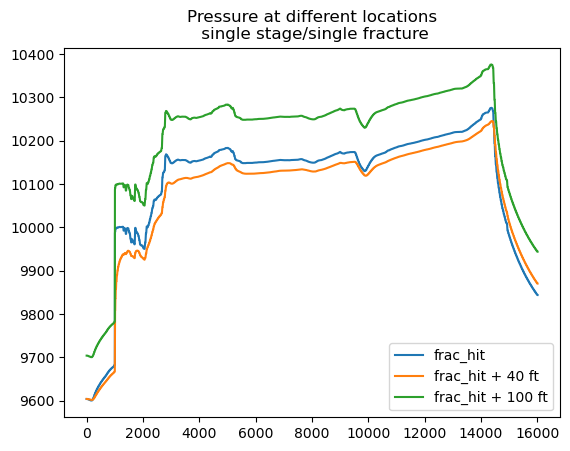

In [20]:
# Plot the result for QC. Check the specific channel.
plt.figure()
plt.plot(t, u_snapshot[:, int(np.where(x == frac_hit_index[0])[0])], label='frac_hit')

plt.plot(t, u_snapshot[:, int(np.where(x == frac_hit_index[0])[0]) + 40], label='frac_hit + 40 ft')

plt.plot(t, u_snapshot[:, int(np.where(x == frac_hit_index[0])[0])] + 100, label='frac_hit + 100 ft')

plt.legend()

plt.title("Pressure at different locations\n single stage/single fracture")
plt.show()

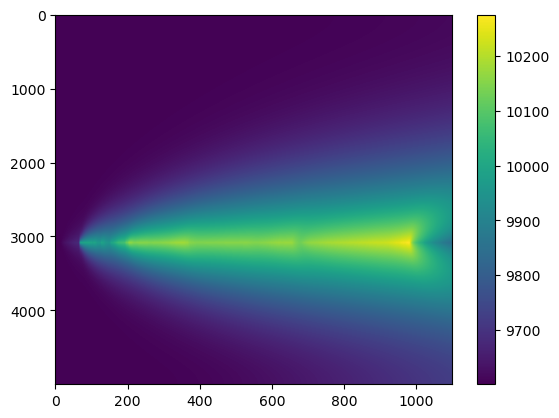

In [21]:
# imshow the result
plt.figure()
plt.imshow(u_snapshot.T, aspect='auto')
plt.colorbar()
plt.show()

# Phase 3: stage 2.

Here I will try different diffusivity drop.

In [22]:
diffusivity_drop_ratio = np.array([0.5, 0.3, 0.1, 0.05, 0.01, 0.001])

In [23]:
# Simulator for phase 3. 
def build_matrix_phase3(dt):
    alpha = d * dt / dx**2
    
    A = np.zeros((nx, nx))
    
    for i in range(1, nx-1):
        A[i, i-1] = -alpha[i]
        A[i, i] = 1 + 2 * alpha[i]
        A[i, i+1] = -alpha[i]
    
    A[0, 0] = 1
    A[-1, -1] = 1
    A[0, 1] = -1
    A[-1, -2] = -1
    
    # Source term
    phase3_frac_hit_index = int(np.where(x == frac_hit_index[1])[0])
    A[phase3_frac_hit_index, :] = 0
    A[phase3_frac_hit_index, phase3_frac_hit_index] = 1
    
    return A

def build_rhs_phase3(u_current, t):
    rhs = u_current.copy()
    rhs[0] = 0
    rhs[-1] = 0
    # Source term.
    phase3_frac_hit_index = int(np.where(x == frac_hit_index[1])[0])
    rhs[phase3_frac_hit_index] = interpolate_gauge_data(t)
    # print(f"Time: {t}, Source: {interpolate_gauge_data(t)}") # debug info
    return rhs

In [24]:
# full step
def full_step_phase3(u_current, dt, t):
    A = build_matrix_phase3(dt)
    rhs = build_rhs_phase3(u_current, t)
    return np.linalg.solve(A, rhs)

# half step
def half_step_phase3(u_current, dt, t):
    dt_half = dt / 2
    A_half = build_matrix_phase3(dt_half)
    rhs_half = build_rhs_phase3(u_current, t)
    u_middle = np.linalg.solve(A_half, rhs_half)
    
    b_half = build_rhs_phase3(u_middle, t)
    u_final = np.linalg.solve(A_half, b_half)
    
    return u_final

In [33]:
def pressure_diffusion_phase3(u_init, d):
    total_time_phase3 = 36898

    dt = dt_init  # Assuming dt_init is defined somewhere above

    # Instead of using arrays for dynamic appending, use Python lists
    taxis_tmp_list = list(t)          # Start with the existing time array converted to a list
    u_snapshot_tmp_list = [u_snapshot]  # Start with a list containing the initial snapshot (which is np.array)

    u_current = u_init.copy()

    while taxis_tmp_list[-1] < total_time_phase3:
        u_current = full_step_phase3(u_current, dt, taxis_tmp_list[-1])
        u_current_half = half_step_phase3(u_current, dt, taxis_tmp_list[-1])
        error = np.linalg.norm(u_current_half - u_current) / np.linalg.norm(u_current)

        dt = adjust_dt(dt, error)

        if error <= 1e-3:
            # Store the snapshot if the error is small enough
            u_snapshot_tmp_list.append(u_current.copy())
            taxis_tmp_list.append(taxis_tmp_list[-1] + dt)

            # Update the time step
            dt = min(dt, 10)
        else:
            # The error is too large, reduce the time step. Don't store the snapshot.
            dt = max(0.5 * dt, 0.5)

        # Store the snapshot again according to your original code logic
        u_snapshot_tmp_list.append(u_current.copy())
        print(f"Time: {taxis_tmp_list[-1]}, Error: {error:.6f}, size = {u_snapshot_tmp_list[-1].shape} and {u_current.shape}")
        taxis_tmp_list.append(taxis_tmp_list[-1] + dt)

    # Convert the lists back to NumPy arrays at the end
    result_snapshot = u_snapshot_tmp_list
    result_t = taxis_tmp_list
    
    return result_snapshot, result_t

In [34]:
# Create phase 3 snapshot, (nx, nt, len(diff_change_ratio))
phase3_snapshots = []
phase3_taxis = []
for diff_ratio in diffusivity_drop_ratio:
    phase1_frac_hit_index = int(np.where(x == frac_hit_index[0])[0]) # get the index of the first fracture
    d_phase3 = deepcopy(d)
    d_phase3[phase1_frac_hit_index:] = d_phase3[phase1_frac_hit_index:] * diff_ratio
    snapshot_tmp, t_tmp = pressure_diffusion_phase3(u_snapshot[-1], d_phase3)
    phase3_snapshots.append(snapshot_tmp)
    phase3_taxis.append(t_tmp)

Time: 16017.7925032648, Error: 0.000434, size = (5000,) and (5000,)
Time: 16041.346100025212, Error: 0.000293, size = (5000,) and (5000,)
Time: 16066.151577287355, Error: 0.000225, size = (5000,) and (5000,)
Time: 16091.955680424639, Error: 0.000185, size = (5000,) and (5000,)
Time: 16118.553512571692, Error: 0.000159, size = (5000,) and (5000,)
Time: 16145.787056057545, Error: 0.000142, size = (5000,) and (5000,)
Time: 16173.533787188468, Error: 0.000130, size = (5000,) and (5000,)
Time: 16201.69742023099, Error: 0.000122, size = (5000,) and (5000,)
Time: 16230.21081726465, Error: 0.000115, size = (5000,) and (5000,)
Time: 16259.015050238211, Error: 0.000110, size = (5000,) and (5000,)
Time: 16288.068665979275, Error: 0.000105, size = (5000,) and (5000,)
Time: 16317.338862416798, Error: 0.000102, size = (5000,) and (5000,)
Time: 16346.802135669966, Error: 0.000099, size = (5000,) and (5000,)
Time: 16376.423718068605, Error: 0.000096, size = (5000,) and (5000,)
Time: 16406.19768798419,

In [59]:
stg3_snapshot_list = []
snapshot_list = []
t_list = []
for i in range(len(diffusivity_drop_ratio)):
    stg3_snapshot_list.append(phase3_snapshots[i][1:])
    t_list.append(phase3_taxis[i])
    # concatenate the snapshot (stage 1 + stage 2)
    snapshot_list.append(np.concatenate((u_snapshot, phase3_snapshots[i][1:]), axis=0))

In [60]:
np.shape(snapshot_list[0])

(2499, 5000)

In [61]:
np.shape(t_list[0])

(2499,)

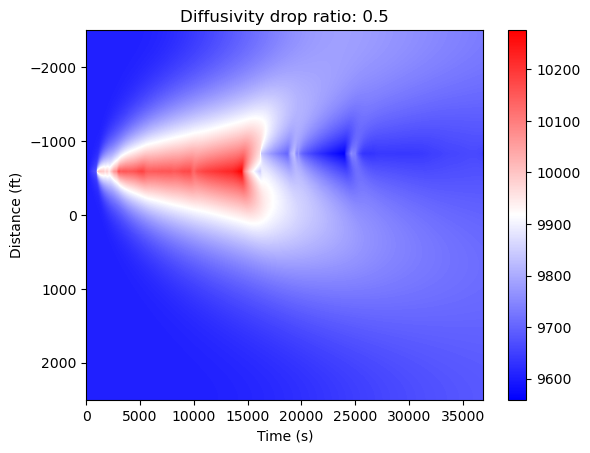

In [64]:
# imshow the result
plt.figure()
plt.imshow(snapshot_list[0].T, aspect='auto', cmap='bwr', extent=[0, 36898, -2500, 2500])
plt.colorbar()
plt.title(f"Diffusivity drop ratio: {diffusivity_drop_ratio[0]}")
plt.xlabel("Time (s)")
plt.ylabel("Distance (ft)")
# invert the y axis
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# based on